## Phân loại cảm xúc trên ảnh

In [5]:
# 1. Tải bộ dữ liệu
! gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=390555e8-3294-4123-8036-3d4ce9e5596c
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:01<00:00, 47.0MB/s]


In [7]:
!unzip -q './FER-2013.zip'

replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# 2.Import các thư viện cần thiết
import cv2 # type: ignore
import os # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.nn.functional as F # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
from torchvision.transforms import Resize # type: ignore
from torchvision.io import read_image # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore

['fear', 'neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust']
{'fear': 0, 'neutral': 1, 'happy': 2, 'sad': 3, 'angry': 4, 'surprise': 5, 'disgust': 6}
{0: 'fear', 1: 'neutral', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'surprise', 6: 'disgust'}
Image height: 128
Image width: 128


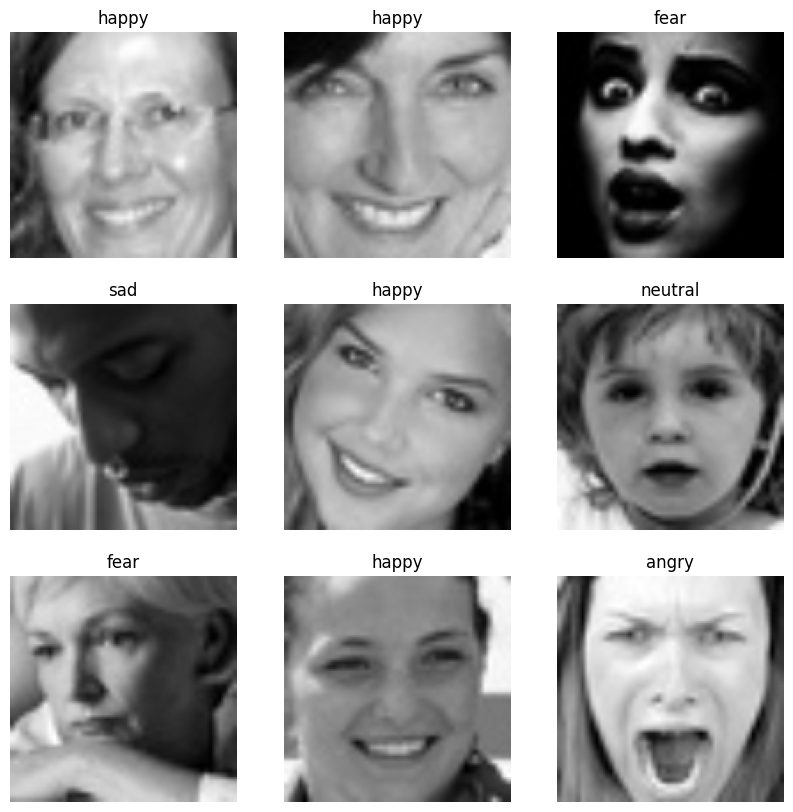

Epoch 1/20, Train Loss: 1.907, Val Loss: 1.880
Epoch 2/20, Train Loss: 1.850, Val Loss: 1.826
Epoch 3/20, Train Loss: 1.807, Val Loss: 1.799
Epoch 4/20, Train Loss: 1.787, Val Loss: 1.783
Epoch 5/20, Train Loss: 1.773, Val Loss: 1.770
Epoch 6/20, Train Loss: 1.759, Val Loss: 1.756
Epoch 7/20, Train Loss: 1.743, Val Loss: 1.740
Epoch 8/20, Train Loss: 1.724, Val Loss: 1.720
Epoch 9/20, Train Loss: 1.702, Val Loss: 1.698
Epoch 10/20, Train Loss: 1.680, Val Loss: 1.678
Epoch 11/20, Train Loss: 1.661, Val Loss: 1.662
Epoch 12/20, Train Loss: 1.645, Val Loss: 1.651
Epoch 13/20, Train Loss: 1.633, Val Loss: 1.641
Epoch 14/20, Train Loss: 1.623, Val Loss: 1.635
Epoch 15/20, Train Loss: 1.613, Val Loss: 1.628
Epoch 16/20, Train Loss: 1.605, Val Loss: 1.622
Epoch 17/20, Train Loss: 1.597, Val Loss: 1.616
Epoch 18/20, Train Loss: 1.589, Val Loss: 1.610
Epoch 19/20, Train Loss: 1.581, Val Loss: 1.607
Epoch 20/20, Train Loss: 1.573, Val Loss: 1.604


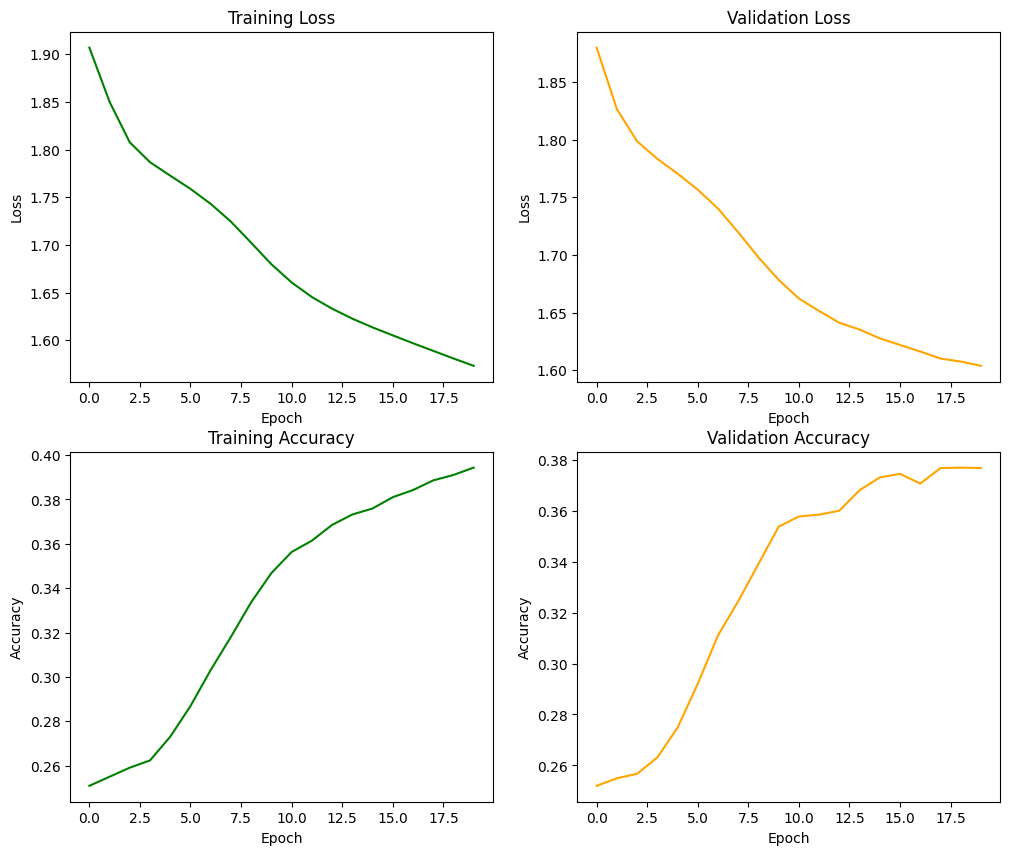

Evaluation on test set: 
Test Accuracy: 0.3884090275842853


In [9]:
# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4. Đọc số lượng class trong dat
train_dir = './train'
test_dir = './test'
classes = os.listdir(train_dir)
label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}
print(classes)
print(label2idx)
print(idx2label)

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')


# 5. Xây dựng DataLoader
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                                                    list(zip(self.img_paths, self.img_labels)),
                                                    train_size=train_ratio,
                                                    random_state=random_state,
                                                    stratify=self.img_labels
                                                )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self): # Corrected indentation
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label


# khởi tạo cho các tập train, val, và test
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# lấy một batch ảnh từ train_loader và hiển thị 9 hình đầu tiên
image_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap='gray')
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis('off')
plt.show()

# 6. Xây dựng mạng MLP
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_height
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)

# 7. Khai báo hàm loss và optimiz
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 8. Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 9. Huấn luyện mô hình
epochs = 20
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')


# trực quan hóa lên đồ thị
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


# 10. Đánh giá mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
val_acc = compute_accuracy(test_predict, test_target)
print('Evaluation on test set: ')
print(f'Test Accuracy: {val_acc}')

## Câu hỏi trắc nghiệm

In [16]:
# Câu 10.1: bỏ phép normalization
# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4. Đọc số lượng class trong dat
train_dir = './train'
test_dir = './test'
classes = os.listdir(train_dir)
label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)


# 5. Xây dựng DataLoader
class ImageDataset101(Dataset):
    def __init__(self, img_dir, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        # self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                                                    list(zip(self.img_paths, self.img_labels)),
                                                    train_size=train_ratio,
                                                    random_state=random_state,
                                                    stratify=self.img_labels
                                                )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self): # Corrected indentation
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        #if self.norm:
            #img = (img/127.5) - 1
        return img, label


# khởi tạo cho các tập train, val, và test
batch_size = 256
# Re-initialize the DataLoader without normalization
train_dataset_no_norm = ImageDataset101(train_dir, label2idx, split='train')
train_loader_no_norm = DataLoader(train_dataset_no_norm, batch_size=batch_size, shuffle=True)

val_dataset_no_norm = ImageDataset101(train_dir, label2idx, split='val')
val_loader_no_norm = DataLoader(val_dataset_no_norm, batch_size=batch_size, shuffle=False)

test_dataset_no_norm = ImageDataset101(test_dir, label2idx, split='test')
test_loader_no_norm = DataLoader(test_dataset_no_norm, batch_size=batch_size, shuffle=False)


# 6. Xây dựng mạng MLP
class MLP_no_norm(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_no_norm, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_height
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model101 = MLP_no_norm(input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)

# 7. Khai báo hàm loss và optimiz
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model101.parameters(), lr=lr)

# 8. Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 9. Huấn luyện mô hình
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model101.train()
    for X_samples, y_samples in train_loader_no_norm:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model101(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader_no_norm)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model101.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader_no_norm:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model101(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader_no_norm)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')


# 10. Đánh giá mô hình
test_target101 = []
test_predict101 = []
model101.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader_no_norm:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model101(X_samples)

        test_predict101.append(outputs.cpu())
        test_target101.append(y_samples.cpu())

test_predict101 = torch.cat(test_predict101)
test_target101 = torch.cat(test_target101)
val_acc101 = compute_accuracy(test_predict101, test_target101)
print('Evaluation on test set: ')
print(f'Test Accuracy: {val_acc101}')

Evaluation on test set: 
Test Accuracy: 0.14265812203956535


In [15]:
# Câu 10.2: bỏ hidden layer thứ 3 trong class “MLP”

# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4. Đọc số lượng class trong dat
train_dir = './train'
test_dir = './test'
classes = os.listdir(train_dir)
label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)


# 5. Xây dựng DataLoader
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                                                    list(zip(self.img_paths, self.img_labels)),
                                                    train_size=train_ratio,
                                                    random_state=random_state,
                                                    stratify=self.img_labels
                                                )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self): # Corrected indentation
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label


# khởi tạo cho các tập train, val, và test
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 6. Xây dựng mạng MLP
class MLPNoHiddenLayer3(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLPNoHiddenLayer3, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.output = nn.Linear(hidden_dims*2, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_height
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

# Re-initialize the model with the modified architecture
model102 = MLPNoHiddenLayer3(input_dims=input_dims,
                            hidden_dims=hidden_dims,
                            output_dims=output_dims).to(device)

# 7. Khai báo hàm loss và optimiz
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model102.parameters(), lr=lr)

# 8. Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 9. Huấn luyện mô hình
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model102.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model102(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model102.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader_no_norm:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model102(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader_no_norm)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')


# 10. Đánh giá mô hình
test_target102 = []
test_predict102 = []
model102.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model102(X_samples)

        test_predict102.append(outputs.cpu())
        test_target102.append(y_samples.cpu())

test_predict102 = torch.cat(test_predict102)
test_target102 = torch.cat(test_target102)
val_acc102 = compute_accuracy(test_predict102, test_target102)
print('Evaluation on test set: ')
print(f'Test Accuracy: {val_acc102}')

Evaluation on test set: 
Test Accuracy: 0.41362496517135694


In [14]:
# Câu 10.3: điều chỉnh số hidden_dims của toàn bộ hidden layer trong class “MLP” bằng nhau

# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4. Đọc số lượng class trong dat
train_dir = './train'
test_dir = './test'
classes = os.listdir(train_dir)
label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls for cls, idx in label2idx.items()}

test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)


# 5. Xây dựng DataLoader
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                                                    list(zip(self.img_paths, self.img_labels)),
                                                    train_size=train_ratio,
                                                    random_state=random_state,
                                                    stratify=self.img_labels
                                                )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self): # Corrected indentation
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img/127.5) - 1
        return img, label


# khởi tạo cho các tập train, val, và test
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 6. Xây dựng mạng MLP
class MLPEqualHiddenDims(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLPEqualHiddenDims, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.linear3 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

input_dims = img_height * img_height
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

# Re-initialize the model with the modified architecture
model103 = MLPEqualHiddenDims(input_dims=input_dims,
                                             hidden_dims=hidden_dims,
                                             output_dims=output_dims).to(device)

# 7. Khai báo hàm loss và optimiz
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model103.parameters(), lr=lr)

# 8. Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 9. Huấn luyện mô hình
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model103.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model103(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model103.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader_no_norm:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model103(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader_no_norm)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')


# 10. Đánh giá mô hình
test_target103 = []
test_predict103 = []
model103.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model103(X_samples)

        test_predict103.append(outputs.cpu())
        test_target103.append(y_samples.cpu())

test_predict103 = torch.cat(test_predict103)
test_target103 = torch.cat(test_target103)
val_acc103 = compute_accuracy(test_predict103, test_target103)
print('Evaluation on test set: ')
print(f'Test Accuracy: {val_acc103}')

Evaluation on test set: 
Test Accuracy: 0.4013652828085818
